# Regridding NARCliM 2.0 Climate Data to a Regular Latitude–Longitude Grid

This notebook demonstrates how to regrid NARCliM 2.0 climate model output from its
native rotated WRF grid (`rlat`, `rlon`) onto a regular latitude–longitude grid
using the xESMF regridding library.

The purpose of this notebook is to demonstrate the regridding of NARCliM 2.0
climate model output from its native rotated WRF grid to a regular
latitude–longitude grid. The focus is on the spatial transformation process,
resulting in gridded data suitable for regional-scale climate analysis and
visualisation.


<a id="top"></a>

## Notebook structure

- [Background and Motivation](#Background-and-Motivation)
- [Regridding Methodology](#Regridding-Methodology)
- [Requirements](#Requirements)
- [Data Access](#Data-Access)
- [Target Grid Definition](#Target-Grid-Definition)
- [Regridding Method](#Regridding-Method)
- [Regridded Output](#Regridded-Output)
- [Native Grid vs Regridded Output](#Native-Grid-vs-Regridded-Output)
- [Regridding Multiple Variables](#Regridding-Multiple-Variables)
- [Saving Regridded Data](#Saving-Regridded-Data)
- [Downstream Use](#Downstream-Use)
- [Summary](#Summary)


## Background and Motivation

NARCliM 2.0 data are produced using the WRF regional climate model, which operates
on a **rotated latitude–longitude grid**. While this grid is well suited for
numerical modelling, it is not directly compatible with many downstream analysis
tasks. To address this, the data are regridded to a **regular latitude–longitude grid**
prior to analysis.

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Regridding Methodology

This notebook uses **xESMF** to regrid climate model output from the native
regional climate model grid to a regular latitude–longitude grid.

xESMF provides several regridding algorithms, each with different trade-offs
between accuracy, conservation, and smoothness.

Commonly used methods include:

- **bilinear** – smooth interpolation, fast, not conservative
- **nearest_s2d / nearest_d2s** – nearest neighbour mapping
- **conservative / conservative_normed** – preserves integrals (e.g. precipitation totals)
- **patch** – higher-order interpolation

In this notebook, we use the *bilinear* method as a default for visualisation
and exploratory analysis.

For a detailed comparison of regridding algorithms, see the official xESMF
documentation:
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Requirements

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
from pathlib import Path
from climate_utils import kelvin_to_celsius
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Data Access

The NARCliM dataset is accessed directly from the NCI THREDDS server using the
OpenDAP protocol and the `xarray` library. This approach avoids local downloads
and enables lightweight, reproducible workflows suitable for demonstration and
exploratory analysis.

The dataset used here is monthly maximum temperature (`tasmax`) from the
NARCliM 2.0 ensemble, but the workflow is applicable to any variable with
spatial dimensions.

In [2]:
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/ssp126/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_mon_201501-201512.nc"
)

ds = xr.open_dataset(url)

In [3]:
print(ds.dims)
print(ds["lat"].dims)
print(ds["lon"].dims)

FrozenMappingWarningOnValuesAccess({'time': 12, 'rlat': 321, 'rlon': 497, 'bnds': 2, 'crs': 1})
('rlat', 'rlon')
('rlat', 'rlon')


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Target Grid Definition

The target grid is defined as a regular latitude–longitude grid over Western Australia at a spatial resolution of approximately 0.05° (~5 km). This resolution represents a practical balance between spatial detail and computational efficiency, and is well suited to regional-scale climate analysis, visualisation, and aggregation workflows.

The spatial extent is selected to fully encompass the Western Australia region of interest while avoiding unnecessary global coverage, ensuring efficient processing and compatibility with common GIS and downstream analysis tools.


In [4]:
target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-38.5, -12.0, 0.05)),  # ~5 km
        "lon": (["lon"], np.arange(108.0, 130.0, 0.05)),
    }
)

target_grid

<xarray.Dataset> Size: 8kB
Dimensions:  (lat: 530, lon: 440)
Coordinates:
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
Data variables:
    *empty*

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Regridding Method

Regridding is performed using the `xESMF` library, which provides a Python
interface to the Earth System Modeling Framework (ESMF).

Bilinear interpolation is used, which is appropriate for continuous climate
variables such as temperature. This method computes each target grid cell
value as a weighted average of the surrounding source grid cells.


In [5]:
regridder = xe.Regridder(
    ds,
    target_grid,
    method="bilinear",
    reuse_weights=False
)

### Why xESMF?

xESMF is used because it:

- Supports curvilinear and rotated grids
- Provides access to multiple regridding algorithms
- Is widely used and validated in the climate science community
- Integrates cleanly with xarray-based workflows

### Regridding caveats

Regridding is an interpolation process and **does not create new physical information**. Users should be aware that:

- Extreme values may be smoothed, particularly with bilinear interpolation
- Local maxima and minima may shift slightly in space
- Results depend on both source grid geometry and target resolution

For analyses sensitive to conservation (e.g. precipitation totals), conservative methods should be used and validated.


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Regridded Output

The result of the regridding process is a dataset with dimensions:

- `time`
- `lat`
- `lon`

The output data are now defined on a regular latitude–longitude grid and are
fully compatible with standard geospatial analysis tools, shapefile overlays,
and regional aggregation workflows.


In [6]:
from climate_utils import kelvin_to_celsius
tasmax_rg = regridder(ds["tasmax"])
tasmax_rg = kelvin_to_celsius(tasmax_rg)

In [7]:
tasmax_rg

<xarray.DataArray (time: 12, lat: 530, lon: 440)> Size: 11MB
array([[[17.35907  , 17.358063 , 17.356628 , ..., 17.644989 ,
         17.646149 , 17.646942 ],
        [17.378143 , 17.376892 , 17.375336 , ..., 17.66336  ,
         17.66397  , 17.66455  ],
        [17.398743 , 17.396667 , 17.394348 , ..., 17.681885 ,
         17.681915 , 17.68216  ],
        ...,
        [29.110596 , 29.105042 , 29.100128 , ..., 30.862396 ,
         30.871704 , 30.87326  ],
        [29.136322 , 29.131012 , 29.126251 , ..., 30.852417 ,
         30.85791  , 30.860077 ],
        [29.158875 , 29.15448  , 29.150635 , ..., 30.843292 ,
         30.84494  , 30.845703 ]],

       [[18.842957 , 18.839417 , 18.837067 , ..., 18.64566  ,
         18.640717 , 18.635498 ],
        [18.871124 , 18.867218 , 18.864197 , ..., 18.664612 ,
         18.659973 , 18.654938 ],
        [18.899414 , 18.895477 , 18.891754 , ..., 18.683502 ,
         18.679138 , 18.674408 ],
...
        [27.851837 , 27.856323 , 27.860962 , ..., 29.453217 ,
         29.466919 , 29.471405 ],
        [27.873596 , 27.877502 , 27.881653 , ..., 29.435242 ,
         29.442657 , 29.447113 ],
        [27.892181 , 27.896484 , 27.901001 , ..., 29.41861  ,
         29.419739 , 29.420807 ]],

       [[17.790863 , 17.7919   , 17.793274 , ..., 16.6604   ,
         16.653046 , 16.646973 ],
        [17.82019  , 17.821198 , 17.822205 , ..., 16.680176 ,
         16.672577 , 16.666412 ],
        [17.850006 , 17.850372 , 17.850677 , ..., 16.700012 ,
         16.6922   , 16.685669 ],
        ...,
        [28.615112 , 28.60971  , 28.60382  , ..., 30.322449 ,
         30.33014  , 30.33374  ],
        [28.630768 , 28.62503  , 28.619354 , ..., 30.311981 ,
         30.31604  , 30.319885 ],
        [28.647064 , 28.641449 , 28.635925 , ..., 30.302307 ,
         30.302704 , 30.304321 ]]], shape=(12, 530, 440), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T12:...
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
    height   float64 8B ...
Attributes:
    regrid_method:  bilinear
    units:          °C

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Native Grid vs Regridded Output

The following plots compare the original model grid with the regridded
regular latitude–longitude grid. This helps illustrate how regridding
changes the spatial representation of the data.


### Native model grid (before regridding)

The plot below shows the data on the native WRF rotated grid.
Because this grid is curvilinear, the spatial extent appears elongated
when plotted in geographic (latitude–longitude) coordinates.


/opt/anaconda3/envs/climate-atlas/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


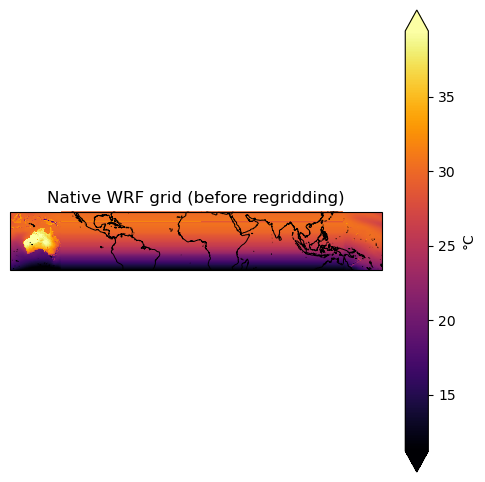

In [8]:
# Native grid (before regridding)
tasmax_native = kelvin_to_celsius(ds["tasmax"].isel(time=0))

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

tasmax_native.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": tasmax_native.attrs.get("units", "degC")}
)

ax.coastlines(resolution="50m", linewidth=0.7)
ax.set_title("Native WRF grid (before regridding)")
plt.show()

The elongated appearance reflects the native rotated WRF grid; the following plot shows the same data after interpolation to a regular latitude–longitude grid.

### Regular latitude–longitude grid (after regridding)

The same data after interpolation to a regular latitude–longitude grid.
This representation is more suitable for analysis and mapping.


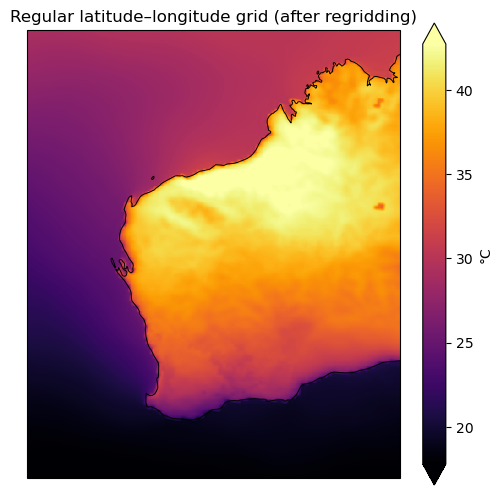

In [9]:
# Regridded output (regular lat–lon grid)
tasmax_regridded = tasmax_rg.isel(time=0)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

tasmax_regridded.plot(
    ax=ax,
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": tasmax_regridded.attrs.get("units", "degC")}
)

ax.coastlines(resolution="50m", linewidth=0.7)
ax.set_title("Regular latitude–longitude grid (after regridding)")
plt.show()


## Regridding multiple variables

This section automatically regrids **all spatial variables** from the original dataset (not just `tasmax`). 

The loop identifies variables with `rlat`/`rlon` dimensions, applies the pre-built regridder, and collects them into a single clean Dataset:



In [10]:
regridded_vars = {}

for var in ds.data_vars:
    da = ds[var]
    if {"rlat", "rlon"}.issubset(da.dims):
        print(f"Regridding {var}")
        regridded_vars[var] = regridder(da)
    else:
        print(f"Skipping {var}")

regridded_ds = xr.Dataset(regridded_vars)
regridded_ds


Regridding tasmax


<xarray.Dataset> Size: 11MB
Dimensions:  (time: 12, lat: 530, lon: 440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T12:...
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
    height   float64 8B ...
Data variables:
    tasmax   (time, lat, lon) float32 11MB 290.5 290.5 290.5 ... 303.5 303.5

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Saving Regridded Data

This finalizes and saves the regridded Dataset to NetCDF with full **provenance metadata**.

 **Add global attributes** documenting source, method, and processing history    
 **Create output directory** safely (`mkdir -p` equivalent)     
 **Save as self-contained `.nc`** file ready for analysis/sharing   

The metadata travels with the file and shows up in `ncdump -h` or `ds.attrs`.


In [11]:
regridded_ds.attrs.update({
    "title": "Regridded NARCliM 2.0 Data",
    "source": "NARCliM 2.0 via NCI THREDDS",
    "regridding_method": "bilinear",
    "original_grid": "WRF rotated lat-lon (rlat, rlon)",
    "notes": "Regridded to regular latitude–longitude grid for analysis"
})


In [12]:
output_dir = Path("output/regridded")
output_dir.mkdir(parents=True, exist_ok=True)

outfile = output_dir / "tasmax_regridded_wa_0p05deg.nc"
regridded_ds.to_netcdf(outfile)

outfile


PosixPath('output/regridded/tasmax_regridded_wa_0p05deg.nc')

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Downstream Use

This notebook is intentionally limited to spatial transformation only.
The regridded NetCDF outputs produced here are intended to be used as inputs
to downstream notebooks that perform:

- aggregation to NRM regions
- temporal statistics
- visualisation and mapping
- stakeholder-focused summaries

This separation of concerns improves clarity, reproducibility, and maintainability
of the overall analysis workflow.
<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Summary

This notebook provides a reproducible example of how to regrid NARCliM 2.0 data
from its native rotated WRF grid to a regular latitude–longitude grid using xESMF.
The resulting datasets form a clean and consistent spatial foundation for
subsequent climate analysis and reporting.


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>